In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.stats import alpha
import folium
import warnings
warnings.filterwarnings('ignore')

### Read Data

In [13]:
start = dt.datetime.now()
raw_train = pd.read_csv("Data/train.csv")
end = dt.datetime.now()
print "Time taken by above cell is {}.".format((end-start))

Time taken by above cell is 0:00:05.594592.


### Temporal Outliers

In [4]:
pd.options.display.float_format = '{:,.3f}'.format
raw_train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count 1,458,644.000    1,458,644.000     1,458,644.000    1,458,644.000   
mean          1.535            1.665           -73.973           40.751   
std           0.499            1.314             0.071            0.033   
min           1.000            0.000          -121.933           34.360   
25%           1.000            1.000           -73.992           40.737   
50%           2.000            1.000           -73.982           40.754   
75%           2.000            2.000           -73.967           40.768   
max           2.000            9.000           -61.336           51.881   

       dropoff_longitude  dropoff_latitude  trip_duration  
count      1,458,644.000     1,458,644.000  1,458,644.000  
mean             -73.973            40.752        959.492  
std                0.071             0.036      5,237.432  
min             -121.933            32.181          1.000  
25%              -73.991            40.736        397.000  
50%              -73.980            40.755        662.000  
75%              -73.963            40.770      1,075.000  
max              -61.336            43.921  3,526,282.000

### Spatial Outliers

In [5]:
city_long_border = (-80, -70)
city_lat_border = (30, 45)
df_out = raw_train[(raw_train.pickup_longitude < city_long_border[0]) 
                  | (raw_train.pickup_longitude > city_long_border[1])
                  | (raw_train.pickup_latitude < city_lat_border[0])
                  | (raw_train.pickup_latitude > city_lat_border[1])
                  | (raw_train.dropoff_longitude < city_long_border[0])
                  | (raw_train.dropoff_longitude > city_long_border[1])
                  | (raw_train.dropoff_latitude < city_lat_border[0])
                  | (raw_train.dropoff_latitude > city_lat_border[1])]
# df_out_sample = df_out.sample(20)
longitudes = list(df_out.pickup_longitude) + list(df_out.dropoff_longitude)
latitudes = list(df_out.pickup_latitude) + list(df_out.dropoff_latitude)

In [6]:
Map = folium.Map(location=[37.4050746, -97.272949], zoom_start=4)
for lat, lon in zip(latitudes, longitudes):
    folium.Marker([lat, lon], popup='<i>Mt. Hood Meadows</i>').add_to(Map)
Map

### Check if there are nonunique or null data

In [7]:
start = dt.datetime.now()
print "ID is unique." if raw_train.id.nunique() == raw_train.shape[0] else "ID is not unique!"
print "No missing data." if raw_train.isnull().sum().sum() == 0 else "Missing data found!"
end = dt.datetime.now()
print "Time taken by above cell is {}.".format((end-start))

ID is unique.
No missing data.
Time taken by above cell is 0:00:00.962655.


### Overview of Data

In [8]:
raw_train.shape

(1458644, 11)

In [9]:
raw_train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1           -73.982           40.768            -73.965   
1                1           -73.980           40.739            -73.999   
2                1           -73.979           40.764            -74.005   
3                1           -74.010           40.720            -74.012   
4                1           -73.973           40.793            -73.973   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0            40.766                  N            455  
1            40.731                  N            663  
2            40.710                  N           2124  
3            40.707                  N            429  
4            40.783                  N            435

In [10]:
raw_train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count 1,458,644.000    1,458,644.000     1,458,644.000    1,458,644.000   
mean          1.535            1.665           -73.973           40.751   
std           0.499            1.314             0.071            0.033   
min           1.000            0.000          -121.933           34.360   
25%           1.000            1.000           -73.992           40.737   
50%           2.000            1.000           -73.982           40.754   
75%           2.000            2.000           -73.967           40.768   
max           2.000            9.000           -61.336           51.881   

       dropoff_longitude  dropoff_latitude  trip_duration  
count      1,458,644.000     1,458,644.000  1,458,644.000  
mean             -73.973            40.752        959.492  
std                0.071             0.036      5,237.432  
min             -121.933            32.181          1.000  
25%              -73.991            40.736        397.000  
50%              -73.980            40.755        662.000  
75%              -73.963            40.770      1,075.000  
max              -61.336            43.921  3,526,282.000

The range of spatial data is too large, indicating some data are out side of New York city. Morevoer, the minimum trip duration is only 1s and the largest one is 3530000s = 3530000 / 3600 = 980.5h, both data are obviously impossible. We need to remove **Outliers**. 

### Data Cleaning

#### Remove data points outside New York City

In [14]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
df_train = raw_train.copy()
df_train = df_train[(df_train.pickup_longitude > city_long_border[0]) & 
                    (df_train.pickup_longitude < city_long_border[1])]
df_train = df_train[(df_train.pickup_latitude > city_lat_border[0]) & 
                    (df_train.pickup_latitude < city_lat_border[1])]
df_train = df_train[(df_train.dropoff_longitude > city_long_border[0]) & 
                    (df_train.dropoff_longitude < city_long_border[1])]
df_train = df_train[(df_train.dropoff_latitude > city_lat_border[0]) & 
                    (df_train.dropoff_latitude < city_lat_border[1])]

#### Remove data points whose trip duration is shorter than 1 minute or longer than 12 hours

In [15]:
duration_range = (60, 3600 * 12)
df_train = df_train[(df_train.trip_duration > duration_range[0]) & 
                    (df_train.trip_duration < duration_range[1])]

In [16]:
df_train.shape

(1429016, 11)

### Plot Spatial Information

In [9]:
start = dt.datetime.now()
longitudes = list(df_train.pickup_longitude) + list(df_train.dropoff_longitude)
latitudes = list(df_train.pickup_latitude) + list(df_train.dropoff_latitude)
sns.set_style('dark')
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
plt.figure(figsize = (10,10))
plt.plot(longitudes, latitudes, '.', alpha=0.8, markersize=0.8)
plt.title("Trips in New York City")
plt.show()
end = dt.datetime.now()
print "Time taken by above cell is {}.".format((end-start))

Time taken by above cell is 0:00:02.091393.


### Clustering

In [11]:
start = dt.datetime.now()
location =  zip(longitudes, latitudes)
kmeans = KMeans(n_clusters=45, random_state=2, n_init = 5).fit(location)
end = dt.datetime.now()
print "Time taken by above cell is {}.".format((end-start))

KeyboardInterrupt: 

In [12]:
df_train['pickup_label'] = kmeans.labels_[:len(kmeans.labels_)/2]
df_train['dropoff_label'] = kmeans.labels_[len(kmeans.labels_)/2:]

In [145]:
points = pd.DataFrame({'longitude': longitudes, 'latitude': latitudes, 'label': kmeans.labels_})
plt.figure(figsize = (10,10))
for label in range(45):
    df = points[points.label == label]
    plt.plot(df.longitude, df.latitude, '.', alpha = 0.5, markersize = 0.8)
plt.title('Clusters of New York City')
plt.show()

### Save Clutsers and Labels to File

In [16]:
with open("Data/cluster_centroids.txt", 'w') as f:
    for centroid in kmeans.cluster_centers_:
        f.write(" ".join(str(x) for x in centroid) + "\n")
with open("Data/label.txt", 'w') as f:
    for label in kmeans.labels_:
        f.write(str(label) + "\n")

## Extract Features

### Compute Haversine Distance

In [17]:
def haversine_distance(data):
    '''This function computes Haversine distance'''
    lon1 = data['pickup_longitude'] * np.pi / 180.0
    lat1 = data['pickup_latitude'] * np.pi / 180.0
    lon2 = data['dropoff_longitude'] * np.pi / 180.0
    lat2 = data['dropoff_latitude'] * np.pi / 180.0
    R = 6378137
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a1 = np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2 
    c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1)) 
    d1 = R * c1
    a2 = (np.sin(dlat/2))**2
    c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
    d2 = R * c2
    data['haversine_distance'] = d1 + d2

haversine_distance(df_train)

### Compute Average Velocity

In [18]:
df_train['velocity'] = df_train.haversine_distance / df_train.trip_duration
df_train = df_train[df_train.velocity < 100]

### Parse Pickup_Datetime

In [19]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_train['pickup_month'] = df_train.pickup_datetime.dt.month
df_train['pickup_day'] = df_train.pickup_datetime.dt.day
df_train['pickup_hour'] = df_train.pickup_datetime.dt.hour
df_train['pickup_minute'] = df_train.pickup_datetime.dt.minute
df_train['pickup_weekday'] = df_train.pickup_datetime.dt.weekday

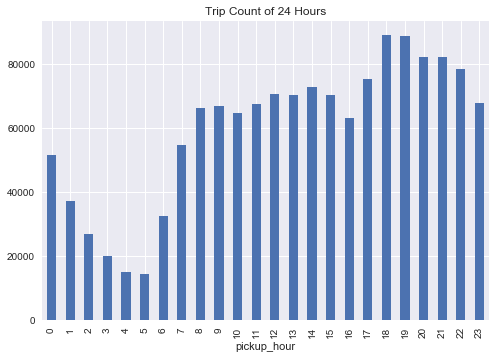

In [20]:
sns.set_style('darkgrid')
df_train.groupby('pickup_hour').size().plot(kind='bar', title='Trip Count of 24 Hours')

In [22]:
df_train.groupby('pickup_weekday').size().plot(kind='bar', title='Trip Count of 7 Weekdays')

In [23]:
df_train.groupby('pickup_month').size().plot(kind='bar', title='Trip Count of 6 Months')

In [24]:
fig, axes = plt.subplots(1, 6, sharey=True, figsize=(15,2))
months = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June"}
grouped_by_month = df_train.groupby('pickup_month')
for i in range(6):
    group = grouped_by_month.get_group(i+1).groupby('pickup_day').size()
    axes[i].bar(group.index, group, width=0.7)
    axes[i].title.set_text("Trip Count of " + months[i+1])

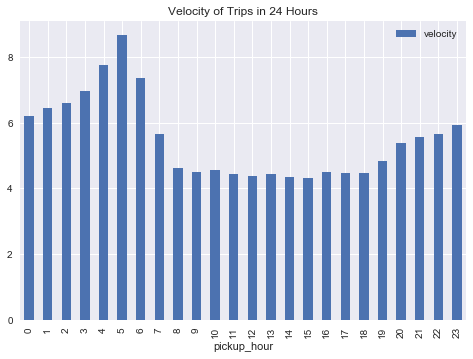

In [25]:
sns.set_style('darkgrid')
df_train.groupby('pickup_hour').agg({'velocity': np.mean}).plot.bar(title='Velocity of Trips in 24 Hours')

In [74]:
start = dt.datetime.now()

grouped_by_hour = df_train.groupby('pickup_hour')
fig, axes = plt.subplots(4, 6)
fig.set_size_inches(18.5, 10.5)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for hour in range(24):
    i, j = hour / 6, hour % 6
    group = grouped_by_hour.get_group(hour)
    params = alpha.fit(group[group.velocity < 25].velocity)
    if params[0] > 1.0:
        good = params
    else:
        params = good
    x = np.linspace(alpha.ppf(0.01, *params), alpha.ppf(0.99, *params), 100)
    axes[i, j].plot(x, alpha.pdf(x, *params), 'r-', lw=3, alpha=0.6)
    axes[i, j].hist(group[group.velocity < 25].velocity, normed=True, bins=60)
    axes[i, j].set_xlabel("velocity(m/s)")
    axes[i, j].set_title("From " + str(hour) + " to " + str(hour+1))
fig.suptitle("Velocity Distribution in 24 Hours")

end = dt.datetime.now()
print "Time taken by above cell is {}.".format((end-start))

Time taken by above cell is 0:00:23.305801.


In [ ]:
df_train.to_csv("Data/featureed_train.csv")

In [2]:
df_train = pd.read_csv("Data/featured_train.csv")

In [6]:
df_train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
df_train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  pickup_label  \
0         40.765602                  N            455             7   
1         40.731152                  N            663            18   
2         40.710087                  N           2124            33   
3         40.706718                  N            429            37   
4         40.782520                  N            435            35   

   dropoff_label  haversine_distance  velocity  pickup_month  pickup_day  \
0             29         1737.403332  3.818469             3          14   
1             10         2433.318384  3.670163             6          12   
2              4         8213.662879  3.867073             1          19   
3              4         1663.211023  3.876949             4           6   
4             42         1200.801312  2.760463             3          26   

   pickup_hour  pickup_minute  pickup_weekday  
0           17             24               0  
1            0             43               6  
2           11             35               1  
3           19             32               2  
4           13             30               5

In [51]:
df_train.shape

(1429012, 20)

In [5]:
train, test = train_test_split(df_train, test_size=0.1)

### Training

In [6]:
records = [[None for weekday in range(7)] for hour in range(24)]
for hour in range(24):
    for weekday in range(7):
        group = train[(train.pickup_hour == hour) & (train.pickup_weekday == weekday)]
        params = alpha.fit(group[group.velocity < 25].velocity)
        if params[0] > 1.0:
            good = params
        else:
            params = good
        records[hour][weekday] = params

In [7]:
test.shape

(142902, 21)

In [13]:
np.random.seed(90)
test['predict_trip_duration'] = np.nan
for hour in range(24):
    for weekday in range(7):
        mask = (test.pickup_hour == hour) & (test.pickup_weekday == weekday)
        a, loc, scale = records[hour][weekday]
        test.loc[mask, 'predict_trip_duration'] = test.loc[mask, 'haversine_distance'] / alpha.rvs(a, loc, scale, np.sum(mask))
print np.sqrt(np.mean((np.log(1 + test.predict_trip_duration) - np.log(1 + test.trip_duration))**2))

0.81862641230410549